In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import dill
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from sklearn.linear_model import LogisticRegression
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.test_statistics.waldo import Waldo
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.plot.power_diagnostics import set_size_plot
from tsi.common.monotone_nn import train_monotonic_nn, MonotonicNN
from tsi.common.utils import IntList, TrainingLogger
from tsi.temp.utils import kdeplots2D

/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Prior: N(0, 2I)
def log_prior(theta):
    return multivariate_normal.logpdf(theta, mean=[0, 0], cov=2*np.eye(2))

# Log-likelihood: log(0.5*N(x|theta,I) + 0.5*N(x|theta,I/10))
def log_likelihood(x, theta):
    ll1 = multivariate_normal.logpdf(x, theta, np.eye(2))
    ll2 = multivariate_normal.logpdf(x, theta, 0.1*np.eye(2))
    return np.logaddexp(ll1 + np.log(0.5), ll2 + np.log(0.5))

# Log posterior (unnormalized)
def log_posterior(theta, x):
    return log_prior(theta) + log_likelihood(x, theta)

def sample_likelihood(theta0, n_samples=10000):
    # Sample X from likelihood at theta0
    n1 = np.random.binomial(n_samples, 0.5)
    x1 = np.random.randn(n1, 2) + theta0  # from N(theta0, I)
    x2 = np.random.randn(n_samples - n1, 2) * np.sqrt(0.1) + theta0  # from N(theta0, I/10)
    x_samples = np.vstack([x1, x2])
    
    return x_samples

# Sample X values to get distribution of log pi(theta0 | X)
def sample_log_posterior_dist(theta0, n_samples=10000):
    # Sample X from likelihood at theta0
    n1 = np.random.binomial(n_samples, 0.5)
    x1 = np.random.randn(n1, 2) + theta0  # from N(theta0, I)
    x2 = np.random.randn(n_samples - n1, 2) * np.sqrt(0.1) + theta0  # from N(theta0, I/10)
    x_samples = np.vstack([x1, x2])
    
    # Compute log posterior for each X
    log_posts = np.array([log_posterior(theta0, x) for x in x_samples])
    return log_posts

In [4]:
def sample_joint_distribution(which_dist, B):
    if which_dist == 'prior':
        b_prime_params = 5.0 * np.random.randn(2*B, 2)
    else:
        b_prime_params = np.random.uniform(-10, 10, 2*B).reshape(-1, 2)
    # b_prime_radius = np.linalg.norm(b_prime_params, axis=1).reshape(-1, 1)
    b_prime_samples = np.vstack([sample_likelihood(theta0, 1) for theta0 in b_prime_params])
    b_prime_test_statistics = np.vstack([log_posterior(theta0, x0) for (theta0, x0) in zip(b_prime_params, b_prime_samples)])
    b_prime_ts = np.random.uniform(b_prime_test_statistics.min(), b_prime_test_statistics.max(), b_prime_test_statistics.shape)

    augmented_inputs, rejection_indicators = np.hstack([b_prime_ts, b_prime_params]), (b_prime_ts > b_prime_test_statistics).astype(int)
    return augmented_inputs, rejection_indicators

augmented_inputs, rejection_indicators = sample_joint_distribution('prior', 10_000)
augmented_inputs_test, rejection_indicators_test = sample_joint_distribution('uniform', 1_000)

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pygam import LogisticGAM, s, te, l, f
import numpy as np

class GAMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, add_radius=True):
        """
        add_radius: If True, expects X of shape (N, 3) and adds radius as 4th column
                    If False, expects X of shape (N, 4) with radius already included
        """
        self.add_radius = add_radius
        self.classes_ = np.array([0, 1])

    def _add_radius_feature(self, X):
        """Add radius as ||theta|| = sqrt(X[:, 1]^2 + X[:, 2]^2)"""
        if not self.add_radius:
            return X
        
        if X.shape[1] != 3:
            raise ValueError(f"Expected X with 3 columns when add_radius=True, got {X.shape[1]}")
        
        radius = np.linalg.norm(X[:, [1, 2]], axis=1, keepdims=True)
        return np.column_stack([X, radius])

    def _build_formula(self):
        """Reconstruct the formula from config"""
        formula = (
            s(0, constraints='monotonic_inc', n_splines=12, spline_order=3) +
            l(3) +
            te(0, 3, n_splines=3, spline_order=2) +
            s(3, constraints='concave', n_splines=6, spline_order=2)
        )
        return formula

    def fit(self, X, y):
        """
        Fit the GAM model.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, 3)
            Features [t, theta1, theta2]
        y : array-like of shape (n_samples,)
            Target values
        """
        # Add radius feature
        X_with_radius = self._add_radius_feature(X)
        
        # Reconstruct the formula inside fit (after cloning)
        self.gam_model_ = LogisticGAM(self._build_formula(), tol=1e-4)
        self.gam_model_.gridsearch(
            X_with_radius,
            y,
            lam=np.logspace(-1, 3, 9),
            progress=False
        )
        return self
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, 3)
            Features [t, theta1, theta2]
        
        Returns
        -------
        array of shape (n_samples,)
            Predicted class labels
        """
        X_with_radius = self._add_radius_feature(X)
        return self.gam_model_.predict(X_with_radius)
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, 3)
            Features [t, theta1, theta2]
        
        Returns
        -------
        array of shape (n_samples, 2)
            Predicted probabilities for each class [P(class=0), P(class=1)]
        """
        X_with_radius = self._add_radius_feature(X)
        probs = self.gam_model_.predict_proba(X_with_radius)
        return np.column_stack([1 - probs, probs])

# Estimate p-value function

In [6]:
estimator = GAMWrapper()
estimator.fit(augmented_inputs, rejection_indicators)

/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/pygam/pygam.py:630: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/pygam/links.py:148: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/home/jcarzon/miniconda3/envs/tsi_upda

,add_radius,True


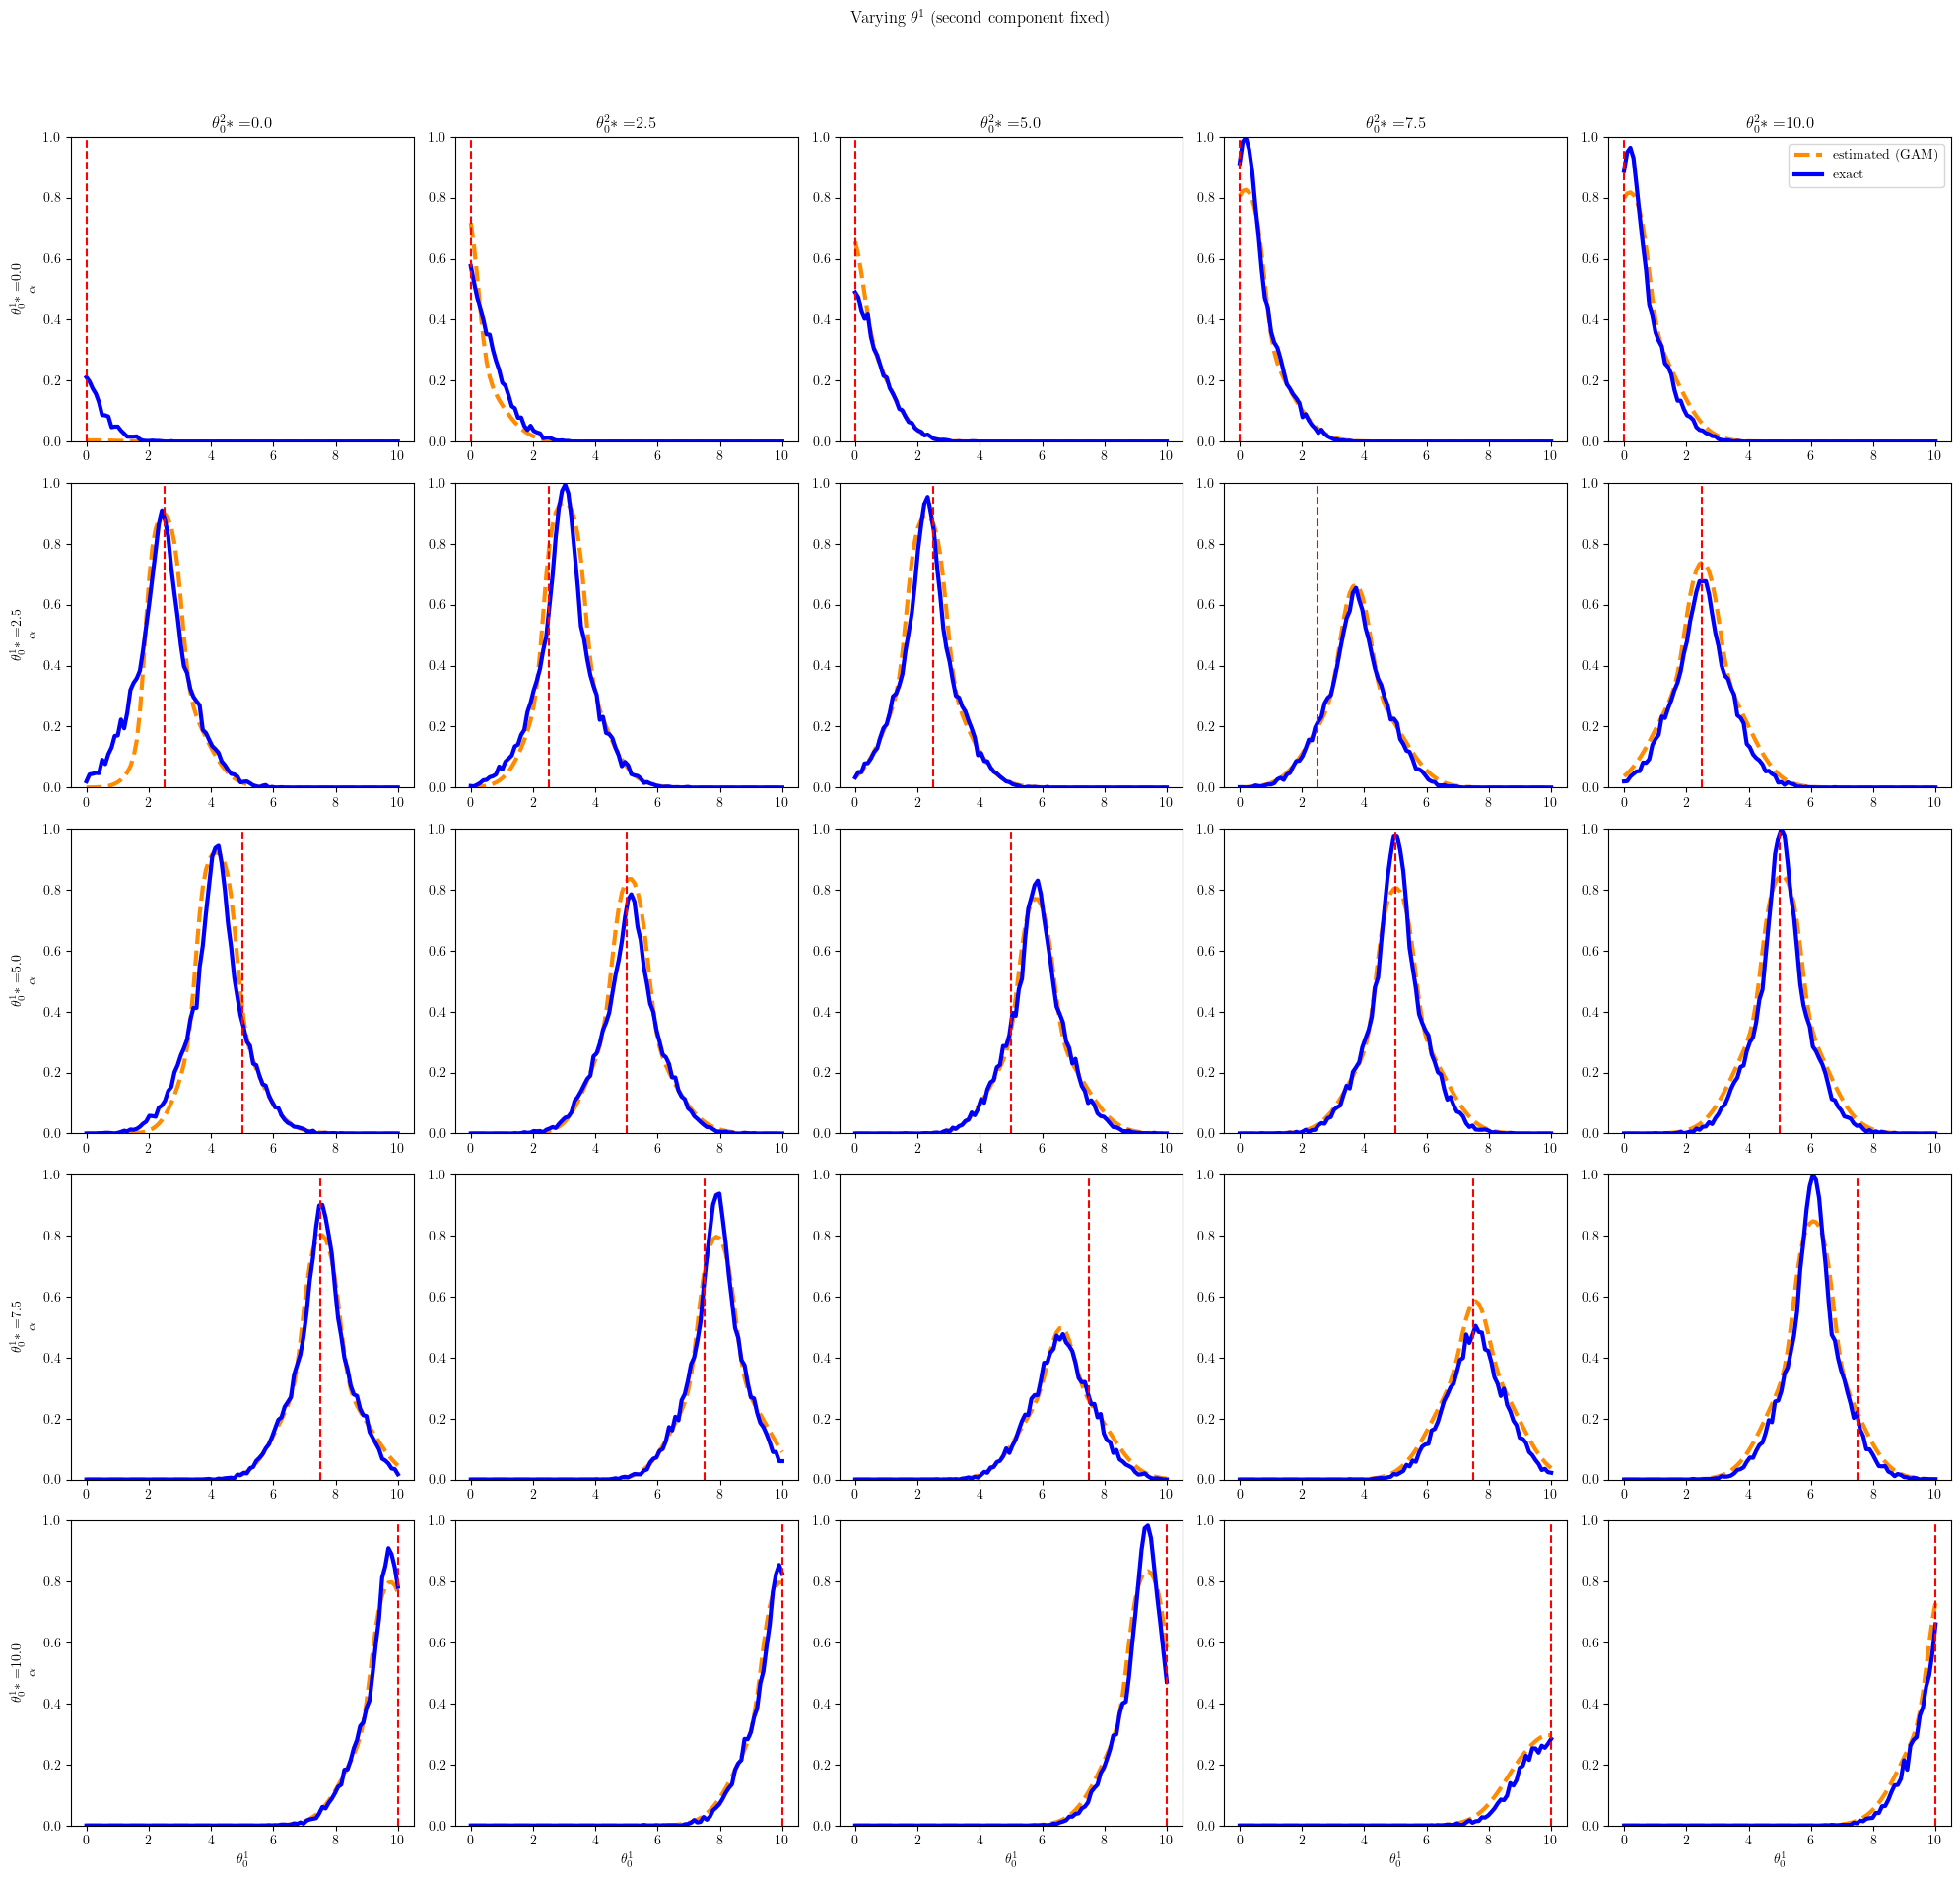

In [8]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
alpha = 0.68
theta_range = np.linspace(0, 10, 100).reshape(-1, 1)

for idx, theta_01 in enumerate(np.linspace(0, 10, 5)):
    for jdx, theta_02 in enumerate(np.linspace(0, 10, 5)):
        theta0 = np.array([theta_01, theta_02])
        theta_grid = np.hstack([theta_range, theta_02*np.ones((100, 1))])
        x_obs = sample_likelihood(theta0, 1)
        t_vals = np.array([log_posterior(theta_i, x_obs) for theta_i in theta_grid]).reshape(-1, 1)
        X = np.hstack([
            t_vals,
            theta_grid
        ])
        p_value_evaluated = estimator.predict_proba(X)[:, 1]
        p_value_exact = np.array([
            np.mean(t_vals[idx] > sample_log_posterior_dist(theta_i, 1_000)) for idx, theta_i in enumerate(theta_grid)
        ])

        ax = axs[idx, jdx]
        ax.plot(theta_range, p_value_evaluated, label='estimated (GAM)', c='darkorange', linestyle='--', linewidth=3)
        ax.plot(theta_range, p_value_exact, label='exact', c='b', linewidth=3)
        ax.axvline(theta0[0], c='r', linestyle='--')
        
        ax.set_ylim(0, 1)
        if idx == 0:
            ax.set_title(f'$\\theta_0^2*=${theta_02}')
            if jdx == 4:
                ax.legend()
        if jdx == 0:
            ax.set_ylabel(f'$\\theta_0^1*=${theta_01}\n$\\alpha$')
        if idx == 4:
            ax.set_xlabel('$\\theta_0^1$')

fig.suptitle('Varying $\\theta^1$ (second component fixed)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay

roc_display = RocCurveDisplay.from_estimator(estimator, augmented_inputs_test, rejection_indicators_test)
plt.title('ROC Curve for Basic GAM')
plt.show()

# roc_display = RocCurveDisplay.from_estimator(estimator_calibrated, augmented_inputs_test, rejection_indicators_test)
# plt.title('ROC Curve for Calibrated GAM')
# plt.show()

# From FMPE posterior

In [ ]:
experiment_id = 0
experiment_dir = f'results/test/mixed_train'
assets_dir = 'results/test/mixed_train'

with open(f'{assets_dir}/fmpe_strong_prior.pkl', 'rb') as f:
    fmpe_posterior = dill.load(f)
with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'rb') as f:
    lf2i = dill.load(f)

In [ ]:
### Settings
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-10, 10), r'$\theta_2$': (-10, 10)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

B = 50_000  # num simulations to estimate posterior and test statistics
B_PRIME = 5_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 5_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 10_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99
MIXING_PROPORTION = 0.0

REFERENCE = PRIOR
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
DEVICE = 'cpu'
task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()

b_prime_params = REFERENCE.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)

In [ ]:
lf2i = LF2I(test_statistic=Posterior(poi_dim=2, estimator=fmpe_posterior, **POSTERIOR_KWARGS))
b_prime_stats = lf2i.test_statistic.evaluate(parameters=b_prime_params, samples=b_prime_samples, mode='critical_values')

In [ ]:
with open('b_prime.pkl', 'wb') as f:
    dill.dump(
        {
            'params': b_prime_params,
            'samples': b_prime_samples,
            'stats': b_prime_stats
        },
        f
    )

In [ ]:
plt.scatter(b_prime_params[:, 0], b_prime_params[:, 1], alpha=0.1)
plt.show()

In [ ]:
class GAMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, add_radius=True):
        """
        add_radius: If True, expects X of shape (N, 3) and adds radius as 4th column
                    If False, expects X of shape (N, 4) with radius already included
        """
        self.add_radius = add_radius
        self.classes_ = np.array([0, 1])

    def _add_radius_feature(self, X):
        """Add radius as ||theta|| = sqrt(X[:, 1]^2 + X[:, 2]^2)"""
        if not self.add_radius:
            return X
        
        if X.shape[1] != 3:
            raise ValueError(f"Expected X with 3 columns when add_radius=True, got {X.shape[1]}")
        
        radius = np.linalg.norm(X[:, [1, 2]], axis=1, keepdims=True)
        return np.column_stack([X, radius])

    def _build_formula(self):
        """Reconstruct the formula from config"""
        formula = (
            s(0, constraints='monotonic_inc', n_splines=12, spline_order=3) +
            l(3) +
            # te(0, 3, n_splines=3, spline_order=2) +
            s(3, constraints='concave', n_splines=6, spline_order=2)
        )
        return formula

    def fit(self, X, y):
        """
        Fit the GAM model.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, 3)
            Features [t, theta1, theta2]
        y : array-like of shape (n_samples,)
            Target values
        """
        # Add radius feature
        X_with_radius = self._add_radius_feature(X)
        
        # Reconstruct the formula inside fit (after cloning)
        self.gam_model_ = LogisticGAM(self._build_formula(), tol=1e-4)
        self.gam_model_.gridsearch(
            X_with_radius,
            y,
            lam=np.logspace(-1, 3, 9),
            progress=False
        )
        return self
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, 3)
            Features [t, theta1, theta2]
        
        Returns
        -------
        array of shape (n_samples,)
            Predicted class labels
        """
        X_with_radius = self._add_radius_feature(X)
        return self.gam_model_.predict(X_with_radius)
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, 3)
            Features [t, theta1, theta2]
        
        Returns
        -------
        array of shape (n_samples, 2)
            Predicted probabilities for each class [P(class=0), P(class=1)]
        """
        X_with_radius = self._add_radius_feature(X)
        probs = self.gam_model_.predict_proba(X_with_radius)
        return np.column_stack([1 - probs, probs])

In [ ]:
from lf2i.calibration.p_values import augment_calibration_set

augmented_inputs_real, rejection_indicators_real = augment_calibration_set(
    test_statistics=b_prime_stats,
    poi=b_prime_params,
    num_augment=10,
    acceptance_region=lf2i.test_statistic.acceptance_region
)
estimator_real = GAMWrapper()
estimator_real.fit(augmented_inputs_real, rejection_indicators_real)

In [ ]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

theta0s = [np.array([0., 0.]), np.array([4, 4]), np.array([8, 8])]

for theta0 in theta0s:
    theta_grid = np.random.uniform(-10, 10, 2_000).reshape(-1, 2)
    # theta_grid = np.hstack([np.random.uniform(theta0[0] - 3, theta0[0] + 3, 100).reshape(-1, 1), np.random.uniform(theta0[1] - 3, theta0[1] + 3, 100).reshape(-1, 1)])
    x_obs = sample_likelihood(theta0, 1)
    t_vals = np.array([log_posterior(theta_i, x_obs) for theta_i in theta_grid]).reshape(-1, 1)

    X = np.hstack([
        t_vals,
        theta_grid
    ])
    # X = np.hstack([X, np.linalg.norm(X[:, [1, 2]], axis=1).reshape(-1, 1)])
    p_value_evaluated = estimator_real.predict_proba(X)[:, 1]

    # # Exact
    # p_value_exact = np.array([
    #     np.mean(t_vals[idx] > sample_log_posterior_dist(theta_i, 500)) for idx, theta_i in enumerate(theta_grid)
    # ])

    gam_set_95 = theta_grid[p_value_evaluated > 0.05]
    gam_set_68 = theta_grid[p_value_evaluated > 0.32]
    # exact_set_95 = theta_grid[p_value_exact > 0.05]
    # exact_set_68 = theta_grid[p_value_exact > 0.32]

    # Create 2D histogram bins
    bins = [np.linspace(theta_grid[:, 0].min(), theta_grid[:, 0].max(), 25),
            np.linspace(theta_grid[:, 1].min(), theta_grid[:, 1].max(), 25)]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # # Plot exact p-values
    # h0 = axs[0].hist2d(theta_grid[:, 0], theta_grid[:, 1], bins=bins, 
    #                     weights=p_value_exact, cmap='viridis', vmin=0, vmax=1)
    # axs[0].set_title('exact')

    # Plot GAM estimates
    h1 = axs[1].hist2d(theta_grid[:, 0], theta_grid[:, 1], bins=bins,
                        weights=p_value_evaluated, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title('estimated (GAM)')

    # fig.colorbar(h2[3], ax=axs[-1])

    for ax in axs:
        ax.set_xlabel('$\\theta_0^1$')
        ax.set_ylabel('$\\theta_0^2$')

    fig.tight_layout()
    fig.show()


    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # # Plot exact p-values
    # h0 = axs[0].scatter(exact_set_95[:, 0], exact_set_95[:, 1], c='lightgreen')
    # axs[0].scatter(exact_set_68[:, 0], exact_set_68[:, 1], c='darkgreen')
    # axs[0].set_title('exact')

    # Plot GAM estimates
    h1 = axs[1].scatter(gam_set_95[:, 0], gam_set_95[:, 1], c='lightgreen')
    axs[1].scatter(gam_set_68[:, 0], gam_set_68[:, 1], c='darkgreen')
    axs[1].set_title('estimated (GAM)')

    for ax in axs:
        ax.scatter(theta0[0], theta0[1], c='r', marker='*')
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        ax.set_xlabel('$\\theta_0^1$')
        ax.set_ylabel('$\\theta_0^2$')

    fig.tight_layout()
    fig.show()